# cNMF in `cellarium-ml`

Stephen Fleming, Yang Xu

2025.07.31

The `cellarium-ml` project:

https://github.com/cellarium-ai/cellarium-ml

The specific implementation of cNMF we are actively working on:

https://github.com/cellarium-ai/cellarium-ml/pull/196

## Overview

`cellarium-ml` implements a variety of algorithms in a way that is scalable to hundreds of millions of cells and beyond.
This notebook provides a demo run of Cellarium's implementation of consensus NMF (cNMF).

Here we demonstrate our ability to run on a large dataset of 4.17M cells.

Because this is intended to run on a laptop, cellarium is running in "streaming" mode where it is continuously downloading files from a google bucket.
This is not the fastest way to run: downloading all curriculum h5ads locally first is much much faster.
This notebook is just a demonstration that it is possible to run without doing a full download all at once.

The specific algorithm for NMF is based on "Online learning for matrix factorization and sparse coding" by Mairal, Bach, Ponce, and Sapiro (JMLR 2010).

## This notebook

This notebook shows an end-to-end cNMF run in `cellarium-ml`, starting with h5ad files and ending with results.
There are several steps involved.

## Description of analysis steps

1. Compute highly-variable genes.

2. Run cNMF on selected highly-variable genes.

3. Interactive plotting in this notebook to help determine optimal number of programs `k`, and a 
   `density_threshold` and `local_neighborhood_size` for the consensus step.

4. Computing consensus factors.

5. (Optional) Computing per-cell factor loadings.

6. (Optional) Re-computing the `k` factor definitions using all genes (not just highly-variable genes).

## Inputs

- a lits of filepaths to h5ad files: can be local or in a google bucket (or at some URL)
    - ideally the h5ad files would be from an extracted curriculum from `cellarium-nexus`, but these files can be any h5ad files
        - until [#324](https://github.com/cellarium-ai/cellarium-ml/issues/324) is resolved, the h5ad files
          should be limited in size to what can fit in memory

## Outputs (work in progress... not complete)

- anndata object for all cells (with an empty count matrix) containing:
    - `adata.obsm["X_cnmf_k20"]`: (cell, k) matrix of per-cell factor loadings (for the `k = 20` decomposition)
    - `adata.obsp["cnmf_k20_factors_hvg"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - from the initial cNMF fit: all non-highly-variable genes have weight zero
    - `adata.obsp["cnmf_k20_factors_hvg_tpm"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - same as above but weights are recomputed to represent TPM values via a refitting step
    - `adata.obsp["cnmf_k20_factors"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - computed by refitting cell loadings from `adata.obsp["cnmf_k20_factors_hvg"]` by refitting the dataset including all genes
    - `adata.obsp["cnmf_k20_factors_tpm"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - same as above but weights are recomputed to represent TPM values via a refitting step
    - (optionally): all of the above for other choices of `k` as well

NOTE: You will need to use the `nmf_sf_singlenotebook` branch of `cellarium-ml` on github

In [8]:
import cellarium.ml.preprocessing
import cellarium.ml.data
import cellarium.ml.transforms
import cellarium.ml.api
import cellarium.ml.models

import lightning.pytorch as pl
import numpy as np

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [3]:
# for demonstration purposes: automatically grab h5ad file paths from a bucket prefix, like data from Nexus

example_cellarium_curriculum_h5ad_paths = cellarium.ml.api.h5ad_paths_from_google_bucket(
    "gs://cellarium-nexus-file-system-335649/pipeline/data-extracts/all_cells_cap_freeze1_20250721/extract_files"
)
print(f"[{example_cellarium_curriculum_h5ad_paths[0]}, ...]")

[gs://cellarium-nexus-file-system-335649/pipeline/data-extracts/all_cells_cap_freeze1_20250721/extract_files/extract_0.h5ad, ...]


In [4]:
# actually here I have mounted the bucket via gcsfuse using this command
# ~/go/bin/gcsfuse -o ro --only-dir pipeline/data-extracts/all_cells_cap_freeze1_20250721/extract_files cellarium-nexus-file-system-335649 /Users/sfleming/Desktop/fuse
# so the files look like they are local at /Users/sfleming/Desktop/fuse

example_cellarium_curriculum_h5ad_paths = [
    f.replace(
        "gs://cellarium-nexus-file-system-335649/pipeline/data-extracts/all_cells_cap_freeze1_20250721/extract_files",
        "/Users/sfleming/Desktop/fuse"
    )
    for f in example_cellarium_curriculum_h5ad_paths
]
print(f"[{example_cellarium_curriculum_h5ad_paths[0]}, ...]")

[/Users/sfleming/Desktop/fuse/extract_0.h5ad, ...]


## Cellarium data setup

For this demo we are using the python API for cellarium.  It's also possible to use command line versions of these tools.

In [5]:
h5ad_paths = example_cellarium_curriculum_h5ad_paths
h5ad_paths[:5]

['/Users/sfleming/Desktop/fuse/extract_0.h5ad',
 '/Users/sfleming/Desktop/fuse/extract_1.h5ad',
 '/Users/sfleming/Desktop/fuse/extract_10.h5ad',
 '/Users/sfleming/Desktop/fuse/extract_100.h5ad',
 '/Users/sfleming/Desktop/fuse/extract_101.h5ad']

In [40]:
len(h5ad_paths)

418

(For remote files over the internet, this next cell can take a minute.)

In [11]:
# counts cells in each file, takes 10 mins

limits = cellarium.ml.api.get_h5ad_files_limits(h5ad_paths)

Reading n_obs from h5ad files: 100%|██████████| 418/418 [06:49<00:00,  1.02file/s]


In [12]:
datamodule = cellarium.ml.CellariumAnnDataDataModule(
    dadc=cellarium.ml.data.DistributedAnnDataCollection(
        filenames=h5ad_paths,
        limits=limits,
        obs_columns_to_validate=[],
        max_cache_size=3,
        cache_size_strictly_enforced=True,
    ),
    batch_keys={
        "x_ng": cellarium.ml.utilities.data.AnnDataField(attr="X", convert_fn=cellarium.ml.utilities.data.densify),
        "var_names_g": cellarium.ml.utilities.data.AnnDataField(attr="var_names"),
        "obs_names_n": cellarium.ml.utilities.data.AnnDataField(attr="obs_names"),
    },
    batch_size=5000,
    shuffle=True,
    train_size=1.0,
    prefetch_factor=2,
    num_workers=8,
    persistent_workers=True,
)

datamodule.setup(stage="fit")

NOTE: It is highly recommended in practice to run this notebook on a machine where you can actually download all the h5ad files. Everything will run much faster.

Try
```
mkdir -p data_extract_h5ads
gsutil -m cp gs://cellarium-nexus-file-system-335649/pipeline/data-extracts/all_cells_cap_freeze1_20250721/extract_files/*.h5ad data_extract_h5ads/
```

and then replace `h5ad_paths` above with local paths.


Example:
- the onepass model below takes about 1.5 hr on 4M cells over my home wifi
- the onepass model below takes about 30 min on 4M cells over my home wifi with gcsfuse
- a onepass model on 4M cells on a local disk should take about 10 mins

# Highly variable genes

## Run onepass model

This computes mean and variance per gene.

In [13]:
# get gene names to use later (and assume all files have the same genes)

var_names_g = cellarium.ml.api.get_h5ad_file_var_names_g(h5ad_paths[0])
var_names_g[:3]

array(['ENSG00000228648', 'ENSG00000234535', 'ENSG00000258171'],
      dtype='<U15')

In [14]:
# set up the model that will be used to compute mean and var of each gene

onepass_module = cellarium.ml.CellariumModule(
    transforms=[
        cellarium.ml.transforms.NormalizeTotal(),
        cellarium.ml.transforms.Log1p(),
    ],
    model=cellarium.ml.models.OnePassMeanVarStd(
        var_names_g=cellarium.ml.api.get_h5ad_file_var_names_g(h5ad_paths[0]),
    )
)

In [15]:
trainer = pl.Trainer(
    accelerator="cpu",
    devices=1,
    max_epochs=1,
    default_root_dir="tmp/onepass",
)
trainer.fit(onepass_module, datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train
-------------------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 835/835 [29:20<00:00,  0.47it/s, v_num=22] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 835/835 [29:20<00:00,  0.47it/s, v_num=22]


In [16]:
# the onepass model computes a mean and variance per gene

mean_g = trainer.model.model.mean_g
var_g = trainer.model.model.var_g

## Compute hvgs

You can choose `n_top_genes` to suit your needs.

In [17]:
var = cellarium.ml.preprocessing.get_highly_variable_genes(
    gene_names=var_names_g,
    mean=mean_g,
    var=var_g,
    n_top_genes=2000,
)
var

means  dispersions            mean_bin  \
ENSG00000228648  2.795660e-04    -0.807515  (-0.00189, 0.0946]   
ENSG00000234535  1.870744e-04    -0.231137  (-0.00189, 0.0946]   
ENSG00000258171  7.916249e-04    -0.508671  (-0.00189, 0.0946]   
ENSG00000275427  1.186585e-03    -1.419282  (-0.00189, 0.0946]   
ENSG00000260750  2.605070e-04    -0.758276  (-0.00189, 0.0946]   
...                       ...          ...                 ...   
ENSG00000232086  4.289922e-08    -1.720334  (-0.00189, 0.0946]   
ENSG00000176797  3.622249e-08    -2.476789  (-0.00189, 0.0946]   
ENSG00000253458  1.000000e-12          NaN  (-0.00189, 0.0946]   
ENSG00000211860  1.045133e-08    -3.132458  (-0.00189, 0.0946]   
ENSG00000211841  1.000000e-12          NaN  (-0.00189, 0.0946]   

                 dispersions_norm  highly_variable  
ENSG00000228648         -0.444780            False  
ENSG00000234535          1.262197            False  
ENSG00000258171          0.440265            False  
ENSG00000275427         -2.256563            False  
ENSG00000260750         -0.298957            False  
...                           ...              ...  
ENSG00000232086         -3.148146            False  
ENSG00000176797         -5.388431            False  
ENSG00000253458               NaN            False  
ENSG00000211860         -7.330234            False  
ENSG00000211841               NaN            False  

[38104 rows x 5 columns]

In [18]:
var['highly_variable'].sum()

2000

In [19]:
# the highly variable genes

hvg_var_names_g = var.index[var['highly_variable']]
hvg_var_names_g

Index(['ENSG00000270164', 'ENSG00000286251', 'ENSG00000251129',
       'ENSG00000287881', 'ENSG00000286778', 'ENSG00000260785',
       'ENSG00000260658', 'ENSG00000232053', 'ENSG00000223725',
       'ENSG00000238755',
       ...
       'ENSG00000211638', 'ENSG00000277745', 'ENSG00000253386',
       'ENSG00000172459', 'ENSG00000244116', 'ENSG00000232030',
       'ENSG00000276638', 'ENSG00000254167', 'ENSG00000254052',
       'ENSG00000181761'],
      dtype='object', length=2000)

# cNMF

## Run NMF

Set things up to run cNMF in cellarium.

With data in a google bucket, 4M cells takes 1.5 hrs per epoch on my `mps` laptop with 20 `k` values and 50 NMF replicates.

Using gcsfuse, it's about the same. First epoch 2 hrs, later epochs 1 hr.

In [20]:
# user's choice for the number of components: must input a python list

# k_values = [10, 20, 30]
k_values = list(range(5, 25))

In [21]:
# user's choice for the number of NMF replicates that should go into consensus

nmf_replicates = 50

In [23]:
# get set up for training

nmf_model = cellarium.ml.models.NonNegativeMatrixFactorization(
    var_names_hvg=hvg_var_names_g,
    k_values=k_values,
    r=nmf_replicates,
)

nmf_module = cellarium.ml.CellariumModule(
    cpu_transforms=[cellarium.ml.transforms.Filter(filter_list=hvg_var_names_g)],
    model=nmf_model,
)

datamodule.setup(stage="fit")

trainer_nmf = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=3,  # this is up for debate, but empirically 5 was enough for the donor regression benchmark
    default_root_dir="tmp/nmf",
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [24]:
# train on the data

pl.seed_everything(0)  # not required but helps make this notebook reproducible

trainer_nmf.fit(nmf_module, datamodule)

Seed set to 0

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train
-------------------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 2: 100%|██████████| 835/835 [1:00:07<00:00,  0.23it/s, v_num=35]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 835/835 [1:00:08<00:00,  0.23it/s, v_num=35]


In [25]:
# see the shape of the NMF gene programs that have been inferred: [replicates, k, genes]

for k in nmf_model.k_values:
    print(getattr(nmf_model, f"D_{k}_rkg").shape)

torch.Size([50, 5, 2000])
torch.Size([50, 6, 2000])
torch.Size([50, 7, 2000])
torch.Size([50, 8, 2000])
torch.Size([50, 9, 2000])
torch.Size([50, 10, 2000])
torch.Size([50, 11, 2000])
torch.Size([50, 12, 2000])
torch.Size([50, 13, 2000])
torch.Size([50, 14, 2000])
torch.Size([50, 15, 2000])
torch.Size([50, 16, 2000])
torch.Size([50, 17, 2000])
torch.Size([50, 18, 2000])
torch.Size([50, 19, 2000])
torch.Size([50, 20, 2000])
torch.Size([50, 21, 2000])
torch.Size([50, 22, 2000])
torch.Size([50, 23, 2000])
torch.Size([50, 24, 2000])


## Set up to explore outputs

We have a helper class that facilitates downstream analysis steps. Here we instantiate it and use it to get various outputs.

In [26]:
from cellarium.ml.models.nmf import NMFOutput

nmf_output = NMFOutput(
    nmf_module=nmf_module,
    datamodule=datamodule,
)

In [27]:
nmf_output

NMFOutput(
    nmf_module=CellariumModule(pipeline = CellariumPipeline(
          (0): Filter(filter_list=['ENSG00000270164' 'ENSG00000286251' 'ENSG00000251129' ...
           'ENSG00000254167' 'ENSG00000254052' 'ENSG00000181761'])
          (1): NonNegativeMatrixFactorization(
            (transform__filter_to_hvgs): Filter(filter_list=['ENSG00000270164' 'ENSG00000286251' 'ENSG00000251129' ...
             'ENSG00000254167' 'ENSG00000254052' 'ENSG00000181761'])
          )
        )),
    datamodule={Train dataloader: size=835}
        {Validation dataloader: size=0}
        {Test dataloader: None}
        {Predict dataloader: None}
)
with consensus []

## Default k-selection plot

This is what Kotliar cNMF would produce with default values for `local_neighborhood_size=0.3` and `density_threshold=0.5`

cellarium.ml.models.nmf - INFO - Computing consensus factors with default hyperparameters...


python(35108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


cellarium.ml.models.nmf - INFO - Calculating reconstruction error (requires an entire pass through the data)...


  0%|          | 0/835 [00:00<?, ?it/s]python(35118) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35120) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35122) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35124) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35129) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35135) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35141) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35172) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 835/835 [45:30<00:00,  3.27s/it]    


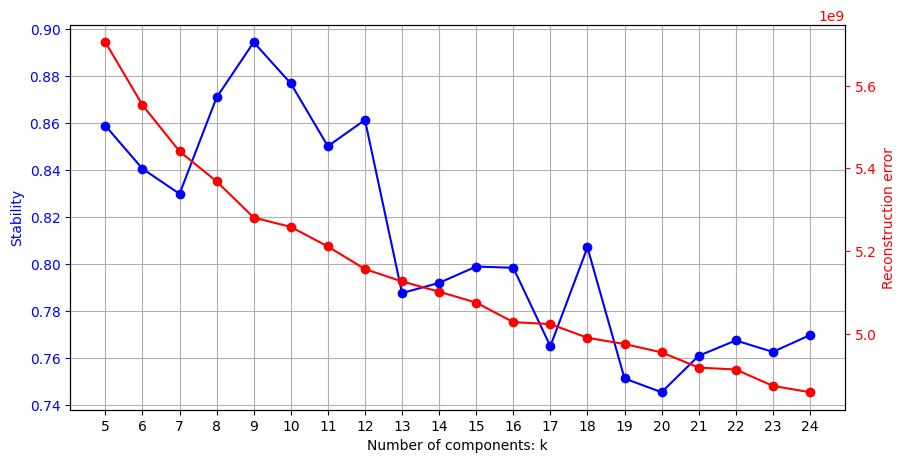

In [28]:
nmf_output.default_k_selection_plot()

## Other versions of the k-selection plot

Kotliar does not demo this, but the k-selection plot itself depends on the values of `density_threshold` and `local_neighborhood_size`.

In principle, you could choose different hyperparameters for each `k`, run `nmf_output.compute_consensus_factors(k, <your selected params here>)` on all the `k`, and then re-run `nmf_output.calculate_reconstruction_error()` and re-create the k-selection plot.

You know, one guiding principle for this process could be the following... for each `k`, automatically choose a (reasonable) `density_threshold` that maximizes the stability for the given `k`. Let's try it.

cellarium.ml.models.nmf - INFO - Computing consensus factors, searching for best density thresholds...


100%|██████████| 20/20 [01:52<00:00,  5.62s/it]

cellarium.ml.models.nmf - INFO - Computing reconstruction errors...



  0%|          | 0/835 [00:00<?, ?it/s]python(37639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37670) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37672) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37675) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37680) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37685) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37690) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 835/835 [45:31<00:00,  3.27s/it]    


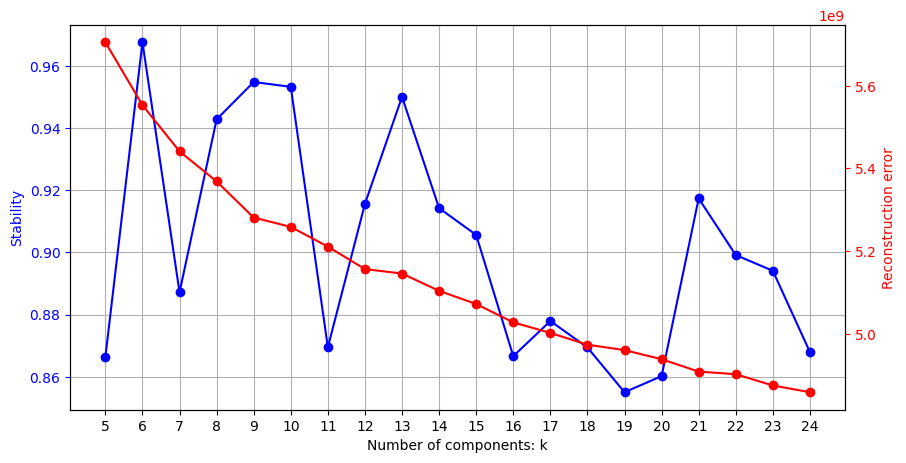

In [29]:
nmf_output.maximal_stability_k_selection_plot()

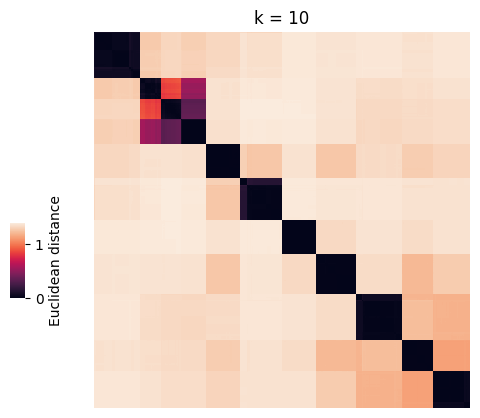

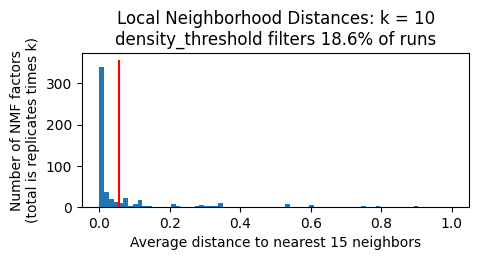

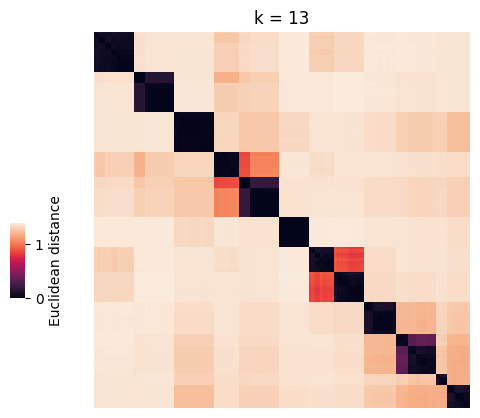

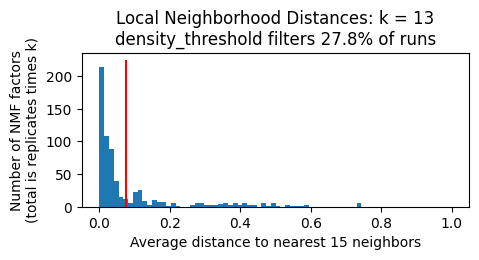

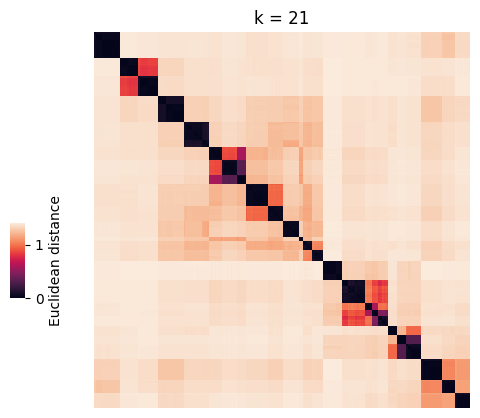

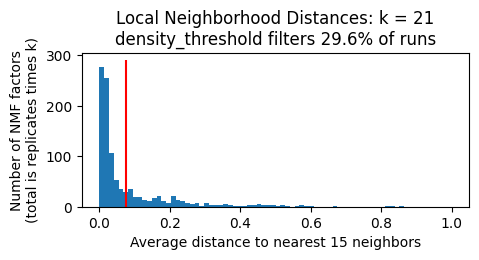

In [42]:
# visualize the results of this kind of automatic choosing of density_threshold
# note that the call to plot_clustermap() recomputes consensus if density_threshold is not None

for k in [10, 13, 21]:  # nmf_output.consensus:
    nmf_output.plot_clustermap(k=k, density_threshold=None)

(The strange thing about the stability metric is that it does not guarantee that there are actually `k` clusters.)

## Explore the factors

In [35]:
best_k = 13

Just look at some of the genes involved

In [36]:
nmf_output.nmf_module.model.var_names_hvg

array(['ENSG00000270164', 'ENSG00000286251', 'ENSG00000251129', ...,
       'ENSG00000254167', 'ENSG00000254052', 'ENSG00000181761'],
      dtype=object)

In [61]:
import pandas as pd

# gene_name_lookup = adata.var['feature_name'].to_dict()

factor_df = pd.DataFrame(nmf_output.consensus[best_k]["consensus_D_kg"].t().numpy(), index=nmf_output.nmf_module.model.var_names_hvg)
# factor_df['gene_name'] = factor_df.index.map(gene_name_lookup)
factor_df

0             1         2             3   \
ENSG00000270164  0.000000e+00  0.000000e+00  0.002257  0.000000e+00   
ENSG00000286251  0.000000e+00  1.972126e-05  0.000000  4.444827e-05   
ENSG00000251129  8.044759e-05  3.484780e-04  0.000084  3.251308e-04   
ENSG00000287881  4.016113e-03  0.000000e+00  0.000000  0.000000e+00   
ENSG00000286778  1.204893e-03  0.000000e+00  0.000000  0.000000e+00   
...                       ...           ...       ...           ...   
ENSG00000232030  0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
ENSG00000276638  0.000000e+00  0.000000e+00  0.000000  1.145954e-08   
ENSG00000254167  0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
ENSG00000254052  4.702384e-08  0.000000e+00  0.000000  0.000000e+00   
ENSG00000181761  0.000000e+00  2.312506e-07  0.000000  0.000000e+00   

                           4             5             6             7   \
ENSG00000270164  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
ENSG00000286251  1.287789e-03  1.924351e-04  0.000000e+00  1.943569e-05   
ENSG00000251129  0.000000e+00  1.696291e-04  9.714799e-05  1.494572e-04   
ENSG00000287881  5.147661e-05  1.050007e-03  0.000000e+00  1.966845e-04   
ENSG00000286778  0.000000e+00  6.701357e-03  6.224125e-04  0.000000e+00   
...                       ...           ...           ...           ...   
ENSG00000232030  2.771792e-08  5.832221e-07  0.000000e+00  8.253637e-09   
ENSG00000276638  0.000000e+00  1.403578e-06  2.744659e-08  2.490022e-08   
ENSG00000254167  0.000000e+00  1.172457e-06  0.000000e+00  2.815239e-08   
ENSG00000254052  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
ENSG00000181761  0.000000e+00  0.000000e+00  0.000000e+00  5.076986e-08   

                           8             9             10            11  \
ENSG00000270164  0.000000e+00  0.000000e+00  9.986967e-04  0.000000e+00   
ENSG00000286251  2.685709e-04  8.641445e-05  0.000000e+00  4.069806e-04   
ENSG00000251129  1.908422e-04  8.346268e-04  2.532212e-05  9.700949e-05   
ENSG00000287881  9.198718e-05  0.000000e+00  0.000000e+00  0.000000e+00   
ENSG00000286778  0.000000e+00  0.000000e+00  0.000000e+00  1.152829e-05   
...                       ...           ...           ...           ...   
ENSG00000232030  9.583085e-07  1.685225e-07  0.000000e+00  2.742239e-07   
ENSG00000276638  5.604650e-07  0.000000e+00  0.000000e+00  0.000000e+00   
ENSG00000254167  5.575426e-07  0.000000e+00  0.000000e+00  0.000000e+00   
ENSG00000254052  0.000000e+00  0.000000e+00  5.463146e-07  0.000000e+00   
ENSG00000181761  4.429065e-07  0.000000e+00  1.322050e-08  8.332758e-09   

                           12  
ENSG00000270164  0.000000e+00  
ENSG00000286251  6.474172e-04  
ENSG00000251129  9.731113e-05  
ENSG00000287881  0.000000e+00  
ENSG00000286778  2.684148e-04  
...                       ...  
ENSG00000232030  2.798687e-07  
ENSG00000276638  0.000000e+00  
ENSG00000254167  0.000000e+00  
ENSG00000254052  0.000000e+00  
ENSG00000181761  0.000000e+00  

[2000 rows x 13 columns]

In [62]:
factor_df.sort_values(by=1, ascending=False).head(10)

0         1         2         3         4         5   \
ENSG00000164199  0.000021  0.006324  0.000000  0.000338  0.000000  0.000000   
ENSG00000234377  0.000000  0.006300  0.000000  0.000000  0.000000  0.000000   
ENSG00000110436  0.000000  0.006225  0.000000  0.000000  0.000000  0.000467   
ENSG00000135540  0.000000  0.006116  0.000385  0.000033  0.000064  0.000564   
ENSG00000164089  0.000000  0.005823  0.000000  0.000000  0.000000  0.000000   
ENSG00000125462  0.000885  0.005763  0.000000  0.000000  0.000000  0.003877   
ENSG00000127249  0.000163  0.005759  0.000000  0.000107  0.000000  0.004558   
ENSG00000271904  0.000715  0.005707  0.000000  0.000077  0.000000  0.000257   
ENSG00000236790  0.000092  0.005693  0.000000  0.000000  0.000000  0.000002   
ENSG00000068078  0.000000  0.005666  0.000000  0.000263  0.000025  0.000548   

                       6         7         8         9         10        11  \
ENSG00000164199  0.000237  0.000000  0.000301  0.000557  0.000000  0.000094   
ENSG00000234377  0.000000  0.000000  0.000000  0.000282  0.000000  0.000051   
ENSG00000110436  0.000057  0.000000  0.000025  0.000000  0.000000  0.000243   
ENSG00000135540  0.000016  0.000000  0.000137  0.000000  0.000183  0.000000   
ENSG00000164089  0.000000  0.000000  0.000000  0.000012  0.000000  0.000000   
ENSG00000125462  0.000819  0.000000  0.000341  0.000000  0.000000  0.000457   
ENSG00000127249  0.000207  0.000140  0.000351  0.000663  0.000000  0.000045   
ENSG00000271904  0.000670  0.000024  0.000689  0.000234  0.000000  0.000177   
ENSG00000236790  0.001004  0.000000  0.000000  0.000686  0.000000  0.000000   
ENSG00000068078  0.000000  0.000000  0.000000  0.000128  0.000000  0.000000   

                       12  
ENSG00000164199  0.000181  
ENSG00000234377  0.000000  
ENSG00000110436  0.000084  
ENSG00000135540  0.000000  
ENSG00000164089  0.000000  
ENSG00000125462  0.000678  
ENSG00000127249  0.000139  
ENSG00000271904  0.000581  
ENSG00000236790  0.001154  
ENSG00000068078  0.000000

In [63]:
factor_df.sort_values(by=2, ascending=False).head(10)

0         1         2         3         4    5   \
ENSG00000018280  0.000045  0.000000  0.005922  0.000000  0.000000  0.0   
ENSG00000137462  0.000000  0.000053  0.005705  0.000000  0.000000  0.0   
ENSG00000110077  0.000000  0.000000  0.005536  0.000000  0.000000  0.0   
ENSG00000143226  0.000000  0.000000  0.005532  0.000000  0.000000  0.0   
ENSG00000028137  0.000000  0.000000  0.005257  0.000000  0.001260  0.0   
ENSG00000163694  0.000138  0.000011  0.005187  0.000332  0.000000  0.0   
ENSG00000166927  0.000000  0.000000  0.004973  0.000000  0.000000  0.0   
ENSG00000081237  0.000000  0.000000  0.004937  0.001148  0.000081  0.0   
ENSG00000180353  0.000037  0.000010  0.004600  0.000000  0.000000  0.0   
ENSG00000122862  0.000092  0.000000  0.004541  0.000000  0.002029  0.0   

                       6         7         8         9         10       11  \
ENSG00000018280  0.000145  0.000000  0.000147  0.000000  0.000000  0.00000   
ENSG00000137462  0.000000  0.000000  0.000000  0.000668  0.000962  0.00000   
ENSG00000110077  0.000000  0.000000  0.000000  0.000000  0.000566  0.00000   
ENSG00000143226  0.000000  0.000018  0.000000  0.000000  0.000560  0.00000   
ENSG00000028137  0.000000  0.000000  0.000146  0.000000  0.000916  0.00000   
ENSG00000163694  0.000182  0.000005  0.000377  0.000094  0.002050  0.00086   
ENSG00000166927  0.000000  0.000000  0.000000  0.000000  0.001477  0.00000   
ENSG00000081237  0.000000  0.000000  0.000000  0.000000  0.002808  0.00000   
ENSG00000180353  0.000050  0.000000  0.000007  0.000000  0.002409  0.00023   
ENSG00000122862  0.000000  0.000000  0.000000  0.000012  0.000386  0.00000   

                       12  
ENSG00000018280  0.000104  
ENSG00000137462  0.000000  
ENSG00000110077  0.000000  
ENSG00000143226  0.000000  
ENSG00000028137  0.000000  
ENSG00000163694  0.000173  
ENSG00000166927  0.000000  
ENSG00000081237  0.000000  
ENSG00000180353  0.000192  
ENSG00000122862  0.000000

In [64]:
factor_df.sort_values(by=5, ascending=False).head(10)

0         1         2         3         4         5   \
ENSG00000116147  0.000614  0.000000  0.000000  0.000000  0.000000  0.011619   
ENSG00000134853  0.000119  0.000000  0.000000  0.000000  0.000014  0.011496   
ENSG00000157890  0.000602  0.000000  0.000000  0.000000  0.000000  0.011405   
ENSG00000038427  0.000000  0.000069  0.000000  0.000135  0.000000  0.011281   
ENSG00000106278  0.000209  0.002703  0.000000  0.000475  0.000000  0.010785   
ENSG00000112280  0.000000  0.000000  0.000000  0.000000  0.000000  0.010685   
ENSG00000278254  0.000000  0.000000  0.000000  0.000000  0.000000  0.010471   
ENSG00000198732  0.000002  0.000000  0.000000  0.001085  0.000000  0.010127   
ENSG00000169129  0.000594  0.000000  0.000000  0.000000  0.001477  0.009946   
ENSG00000103489  0.000548  0.000055  0.000019  0.000235  0.000000  0.009561   

                       6         7         8         9         10        11  \
ENSG00000116147  0.002934  0.000000  0.000194  0.000000  0.000000  0.000235   
ENSG00000134853  0.000000  0.000000  0.000176  0.000000  0.000000  0.000000   
ENSG00000157890  0.000071  0.000000  0.000335  0.000000  0.000000  0.000000   
ENSG00000038427  0.000000  0.000000  0.000000  0.001350  0.000000  0.000000   
ENSG00000106278  0.000000  0.000000  0.000000  0.001825  0.000000  0.000000   
ENSG00000112280  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ENSG00000278254  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ENSG00000198732  0.000000  0.000580  0.000000  0.000040  0.000000  0.000000   
ENSG00000169129  0.001008  0.000000  0.000240  0.000000  0.000000  0.000140   
ENSG00000103489  0.003820  0.000123  0.000821  0.000176  0.000003  0.001013   

                       12  
ENSG00000116147  0.002600  
ENSG00000134853  0.000000  
ENSG00000157890  0.000076  
ENSG00000038427  0.000000  
ENSG00000106278  0.000000  
ENSG00000112280  0.000000  
ENSG00000278254  0.000000  
ENSG00000198732  0.000000  
ENSG00000169129  0.000955  
ENSG00000103489  0.003405

In [65]:
factor_df.sort_values(by=6, ascending=False).head(10)

0         1    2         3         4         5   \
ENSG00000141668  0.000000  0.000000  0.0  0.000010  0.000000  0.000000   
ENSG00000233290  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
ENSG00000256193  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
ENSG00000146147  0.000000  0.000000  0.0  0.000326  0.000000  0.000000   
ENSG00000111249  0.003591  0.000000  0.0  0.000000  0.000000  0.000130   
ENSG00000263551  0.000000  0.000000  0.0  0.000000  0.000048  0.000000   
ENSG00000224271  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
ENSG00000216863  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
ENSG00000229618  0.000000  0.000000  0.0  0.000019  0.000000  0.000000   
ENSG00000183662  0.000000  0.000146  0.0  0.000005  0.000000  0.000771   

                       6    7         8    9             10        11  \
ENSG00000141668  0.009321  0.0  0.000000  0.0  0.000000e+00  0.000000   
ENSG00000233290  0.009005  0.0  0.000000  0.0  0.000000e+00  0.000000   
ENSG00000256193  0.008935  0.0  0.000000  0.0  0.000000e+00  0.000000   
ENSG00000146147  0.008803  0.0  0.000000  0.0  0.000000e+00  0.000000   
ENSG00000111249  0.008700  0.0  0.000000  0.0  0.000000e+00  0.000000   
ENSG00000263551  0.008593  0.0  0.000000  0.0  0.000000e+00  0.001962   
ENSG00000224271  0.008278  0.0  0.000000  0.0  0.000000e+00  0.000000   
ENSG00000216863  0.008173  0.0  0.000000  0.0  6.516233e-07  0.000000   
ENSG00000229618  0.008159  0.0  0.001651  0.0  0.000000e+00  0.000000   
ENSG00000183662  0.008109  0.0  0.000012  0.0  0.000000e+00  0.000730   

                       12  
ENSG00000141668  0.005972  
ENSG00000233290  0.006298  
ENSG00000256193  0.005272  
ENSG00000146147  0.007145  
ENSG00000111249  0.005434  
ENSG00000263551  0.005652  
ENSG00000224271  0.006639  
ENSG00000216863  0.006695  
ENSG00000229618  0.005679  
ENSG00000183662  0.006818

## Compute per-cell loadings

In [43]:
best_k

13

In [ ]:
# pick ten h5ad files and load data (cells are randomly shuffled)
# in theory this could be done for all cells, but I have no use for that here

n_cells_visualization = 100_000
n_anndata_shards_visualization = n_cells_visualization // 10_000

datamodule_small = cellarium.ml.CellariumAnnDataDataModule(
    dadc=cellarium.ml.data.DistributedAnnDataCollection(
        filenames=h5ad_paths[:n_anndata_shards_visualization],
        limits=limits[:n_anndata_shards_visualization],
        obs_columns_to_validate=[],
        max_cache_size=n_anndata_shards_visualization,
        cache_size_strictly_enforced=True,
    ),
    batch_keys={
        "x_ng": cellarium.ml.utilities.data.AnnDataField(attr="X", convert_fn=cellarium.ml.utilities.data.densify),
        "var_names_g": cellarium.ml.utilities.data.AnnDataField(attr="var_names"),
        "obs_names_n": cellarium.ml.utilities.data.AnnDataField(attr="obs_names"),
    },
    batch_size=5000,
    shuffle=False,
    train_size=1.0,
    prefetch_factor=None,
    num_workers=None,
    persistent_workers=False,
)

datamodule_small.setup(stage="predict")

The loadings of each factor, computed for each cell.

In [82]:
# get per-cell factor loadings using the best k: this takes time
# `normalize` controls whether the per-cell loadings sum to 1

df = nmf_output.compute_loadings(k=best_k, datamodule=datamodule_small, normalize=True)

  0%|          | 0/20 [00:00<?, ?it/s]python(41793) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41802) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41805) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41812) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 20/20 [01:58<00:00,  5.91s/it]


In [83]:
df.shape

(100000, 13)

In theory could add this information to the anndata object if you had a single object.
Here we will assume the dataset might be very large in total, so we will just try to grab a chunk of data and add the annotations for those cells.

In [84]:
# grab cells as anndata object (this might take time to download data from bucket)

adata = datamodule_small.dadc[:n_cells_visualization]
if adata.raw is not None:
    adata.layers['counts'] = adata.raw.X.copy()
else:
    adata.layers['counts'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 100000 × 38104
    obs: 'original_id', 'donor_id', 'cell_type', 'assay', 'development_stage', 'tissue', 'disease', 'organism', 'self_reported_ethnicity', 'sex', 'suspension_type', 'total_mrna_umis', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'tag', 'brain_region_abbreviation', 'cohort', 'data_freeze', 'frac_contamination', 'neuropath_diagnosis', 'scpred_class', 'toxicology_compounds_detected', 'toxicology_group', 'village'
    layers: 'counts'

In [85]:
# add cNMF loadings to obsm

adata.obsm["X_nmf"] = df.loc[adata.obs_names].values
adata.obsm["X_nmf"].shape

(100000, 13)

### Visualize factor loadings on a UMAP

Just for fun, if you have scanpy installed in your environment.

In [86]:
import scanpy as sc

In [87]:
sc.set_figure_params(figsize=(5, 5), fontsize=14, vector_friendly=True)

In [88]:
sc.pp.highly_variable_genes(adata, layer='counts', flavor='seurat_v3', n_top_genes=2000)

In [89]:
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
# sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata, method='umap', metric='cosine', n_pcs=10)
sc.tl.umap(adata)
adata.obsm["X_umap_counts"] = adata.obsm["X_umap"].copy()

In [90]:
# put these in obs for plotting

for k in range(adata.obsm["X_nmf"].shape[1]):
    adata.obs[f"nmf_{k}"] = adata.obsm["X_nmf"][:, k]

In [91]:
adata.obs.columns

Index(['original_id', 'donor_id', 'cell_type', 'assay', 'development_stage',
       'tissue', 'disease', 'organism', 'self_reported_ethnicity', 'sex',
       'suspension_type', 'total_mrna_umis', 'cell_type_ontology_term_id',
       'assay_ontology_term_id', 'development_stage_ontology_term_id',
       'tissue_ontology_term_id', 'disease_ontology_term_id',
       'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'sex_ontology_term_id', 'tag', 'brain_region_abbreviation', 'cohort',
       'data_freeze', 'frac_contamination', 'neuropath_diagnosis',
       'scpred_class', 'toxicology_compounds_detected', 'toxicology_group',
       'village', 'nmf_0', 'nmf_1', 'nmf_2', 'nmf_3', 'nmf_4', 'nmf_5',
       'nmf_6', 'nmf_7', 'nmf_8', 'nmf_9', 'nmf_10', 'nmf_11', 'nmf_12'],
      dtype='object')

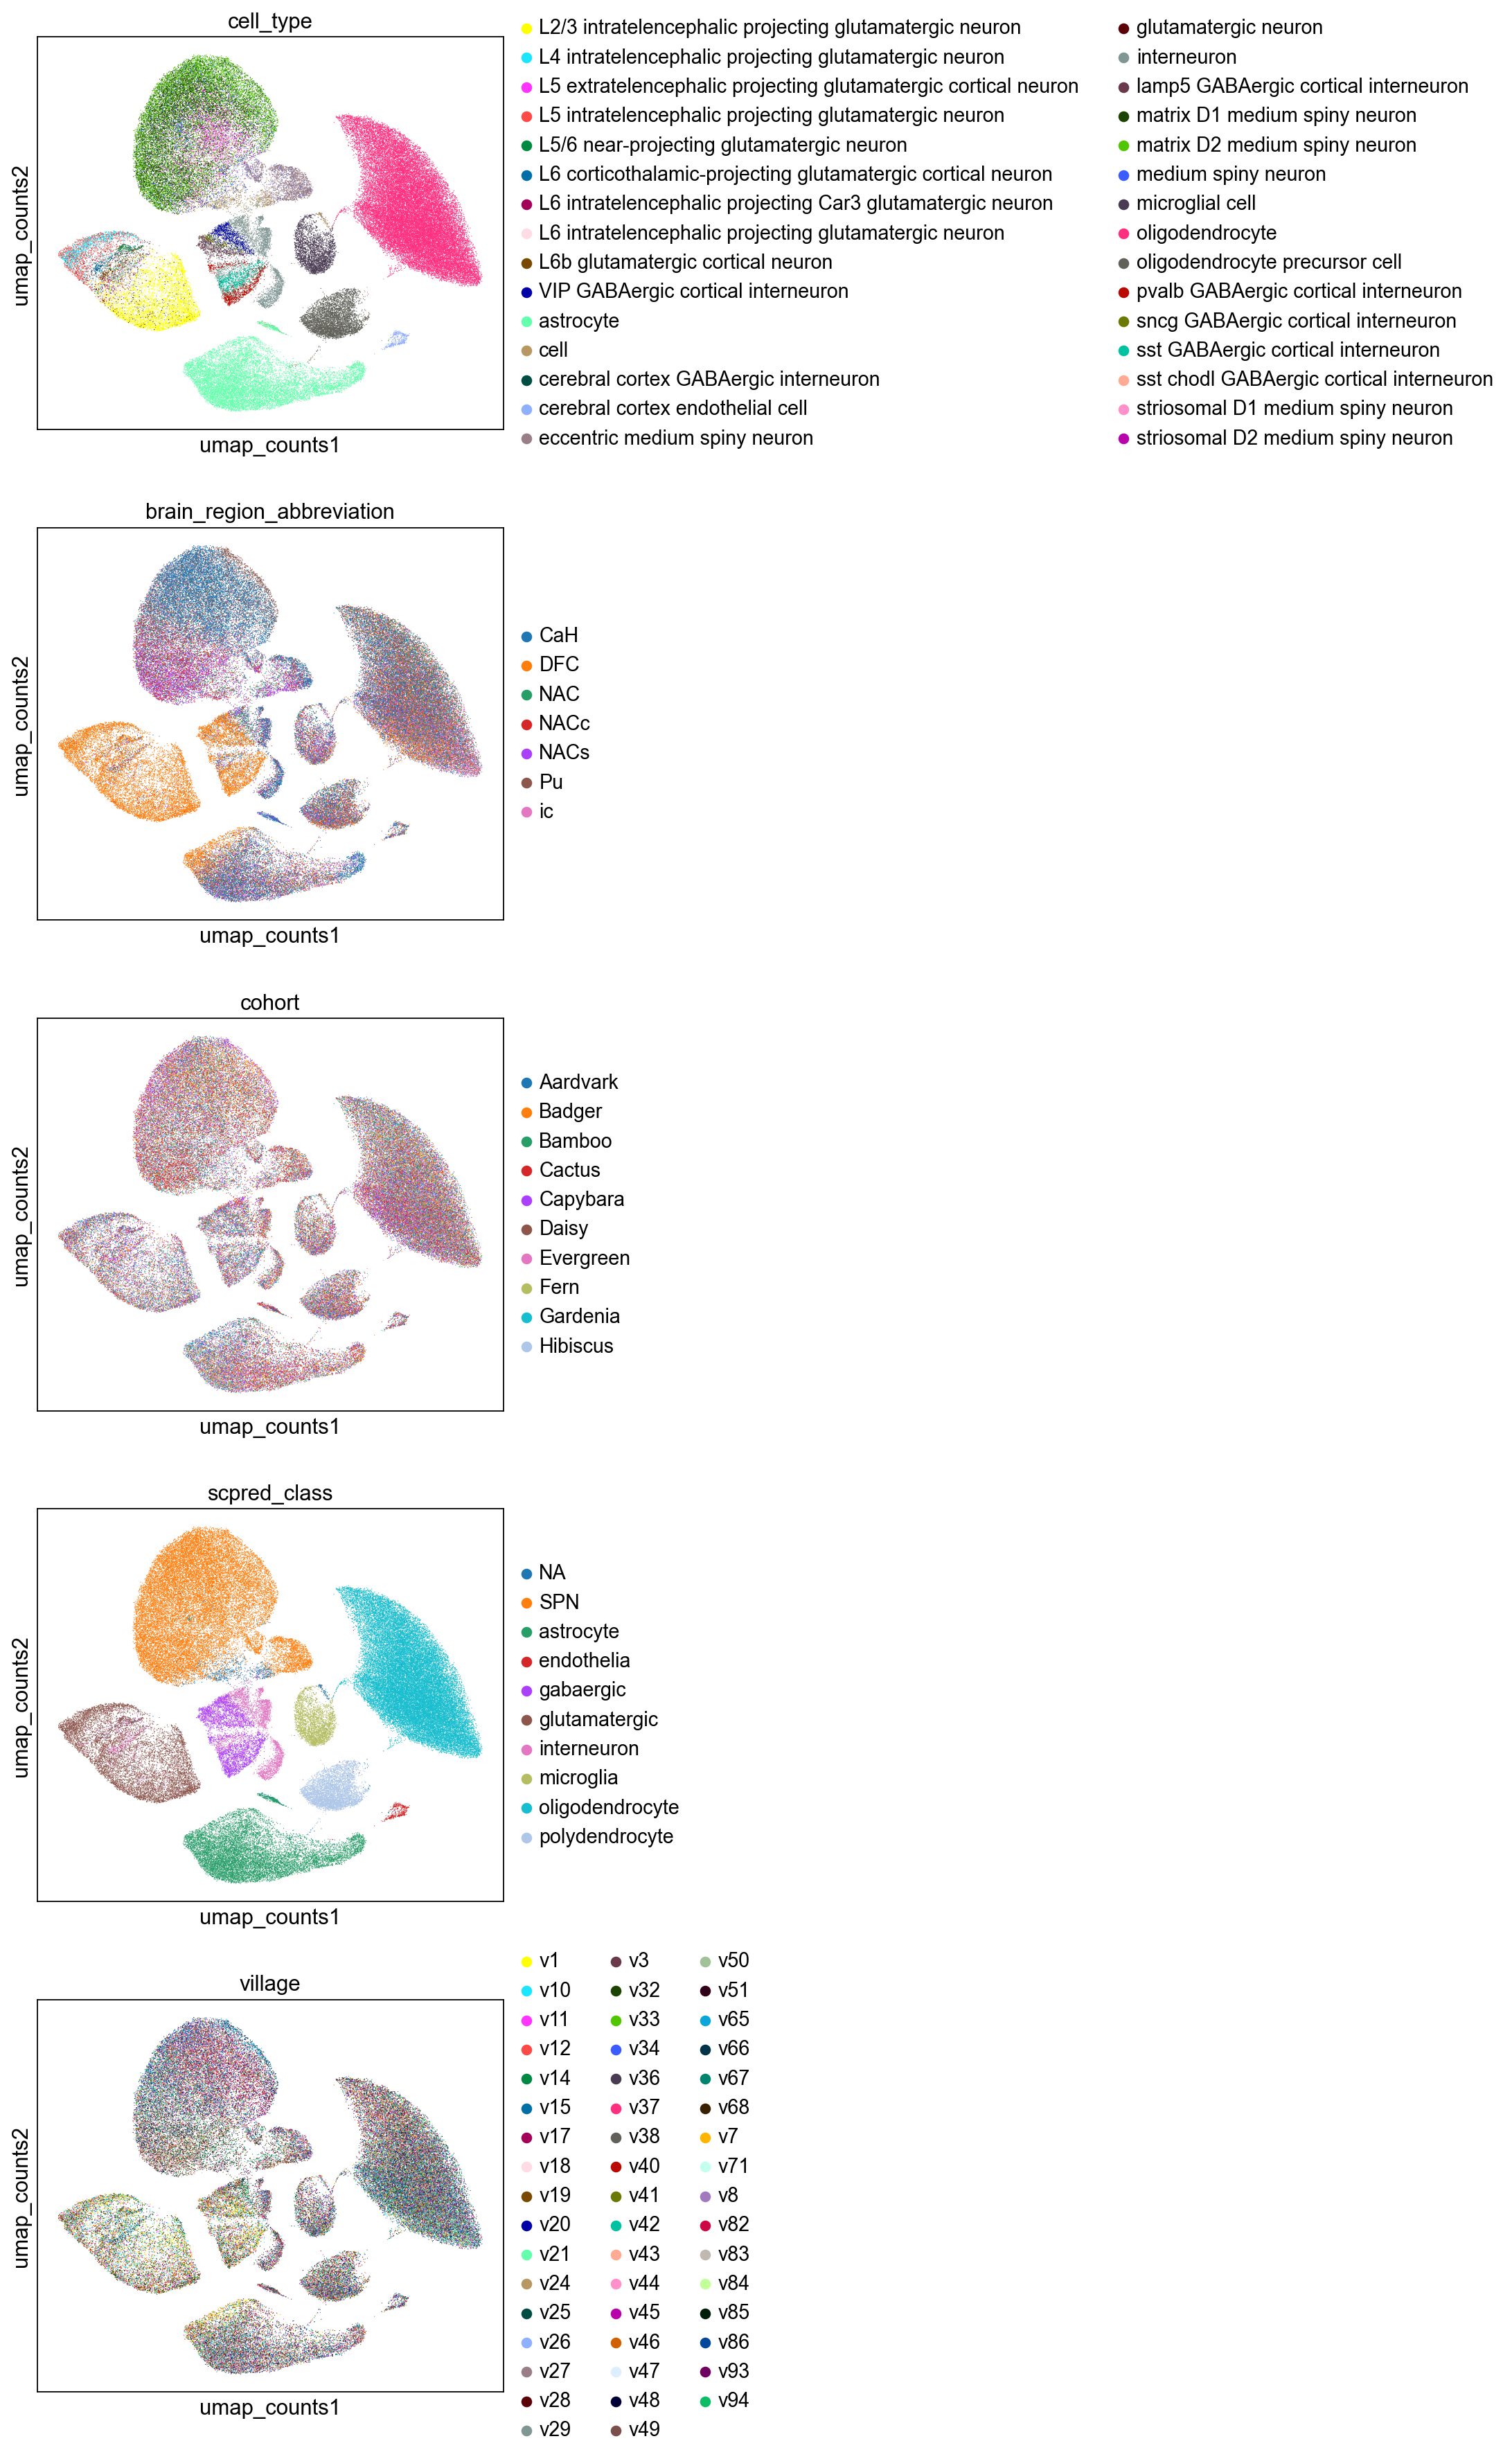

In [92]:
sc.pl.embedding(
    adata, 
    basis='umap_counts', 
    color=['cell_type', 'brain_region_abbreviation', 'cohort', 'scpred_class', 'village'], 
    # color_map='Oranges', 
    ncols=1,
)

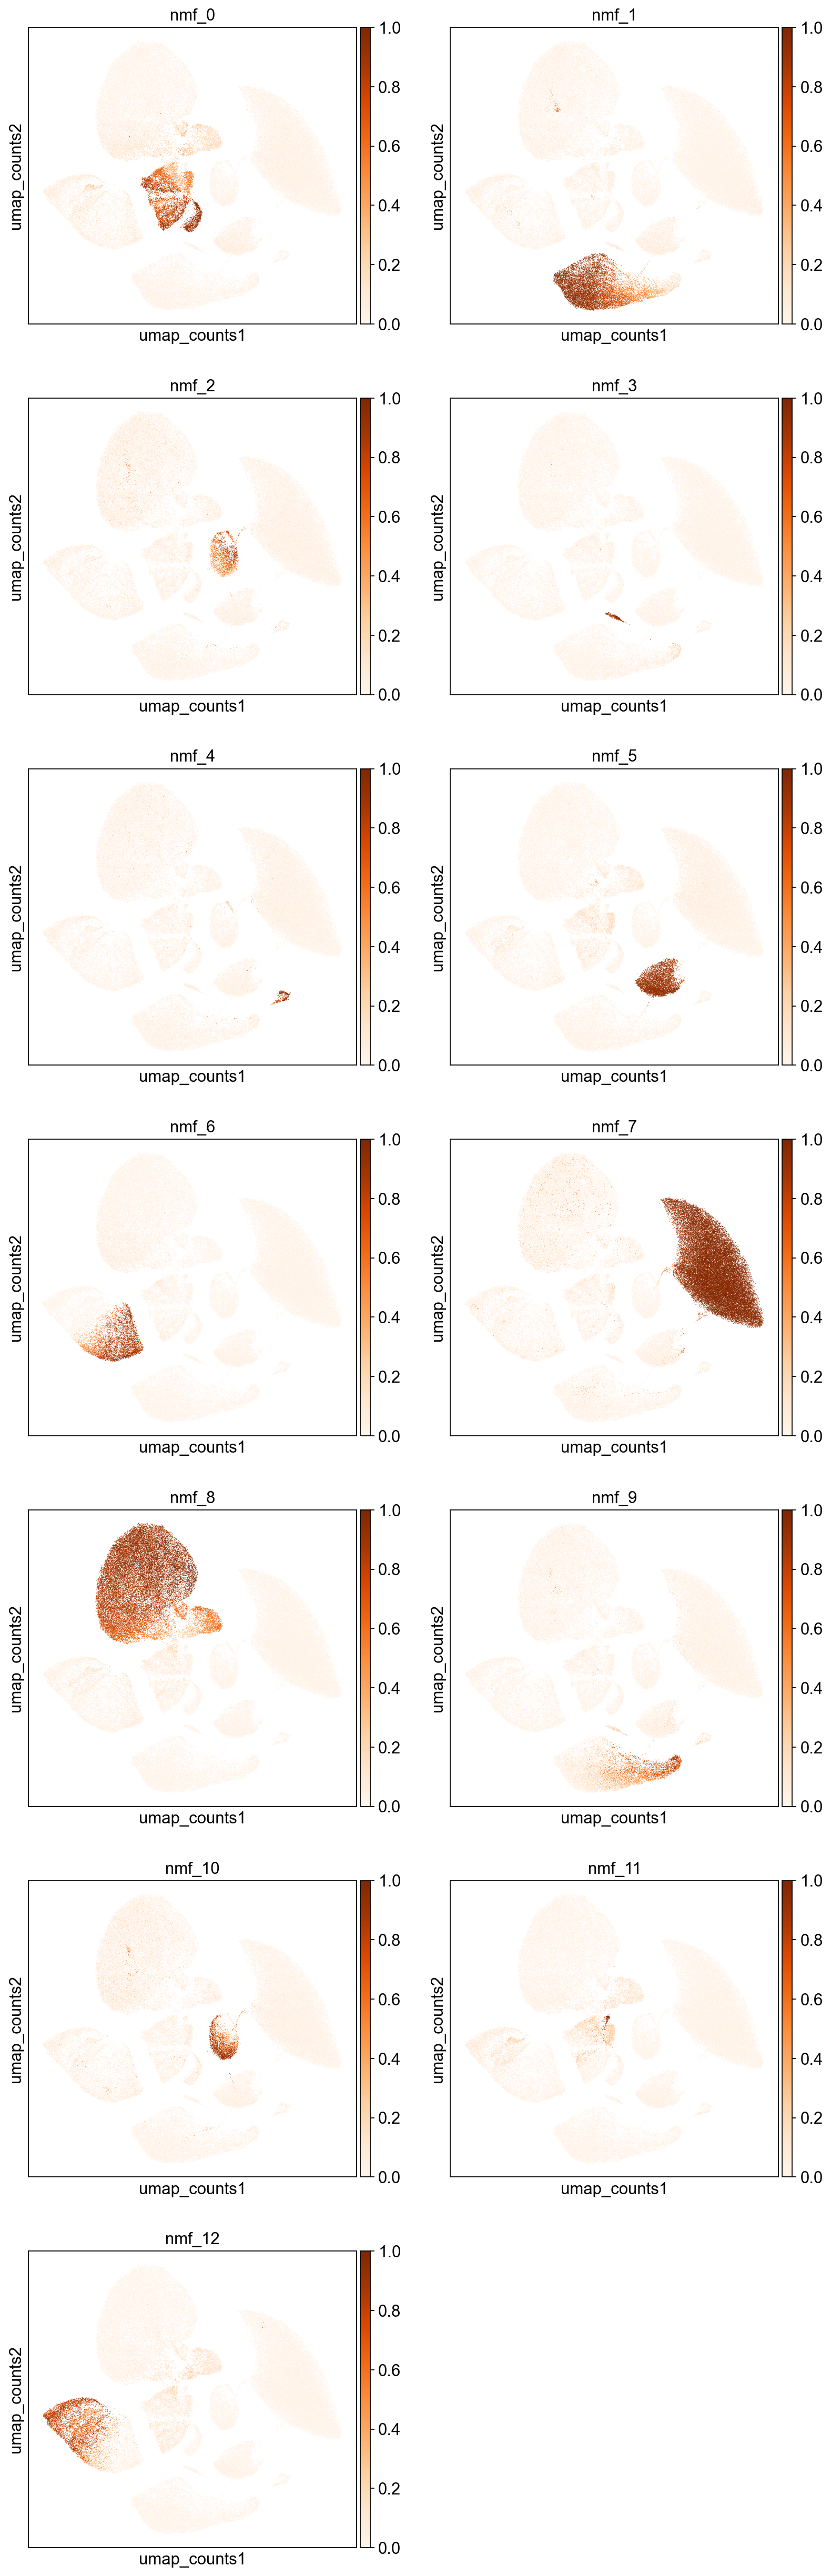

In [93]:
sc.pl.embedding(adata, basis='umap_counts', color=[f'nmf_{i}' for i in range(0, best_k)], color_map='Oranges', ncols=2)

In [94]:
# try a UMAP derived from the NMF components

sc.pp.neighbors(adata, use_rep='X_nmf', method='umap', metric='cosine')
sc.tl.umap(adata)
adata.obsm["X_umap_nmf"] = adata.obsm["X_umap"].copy()

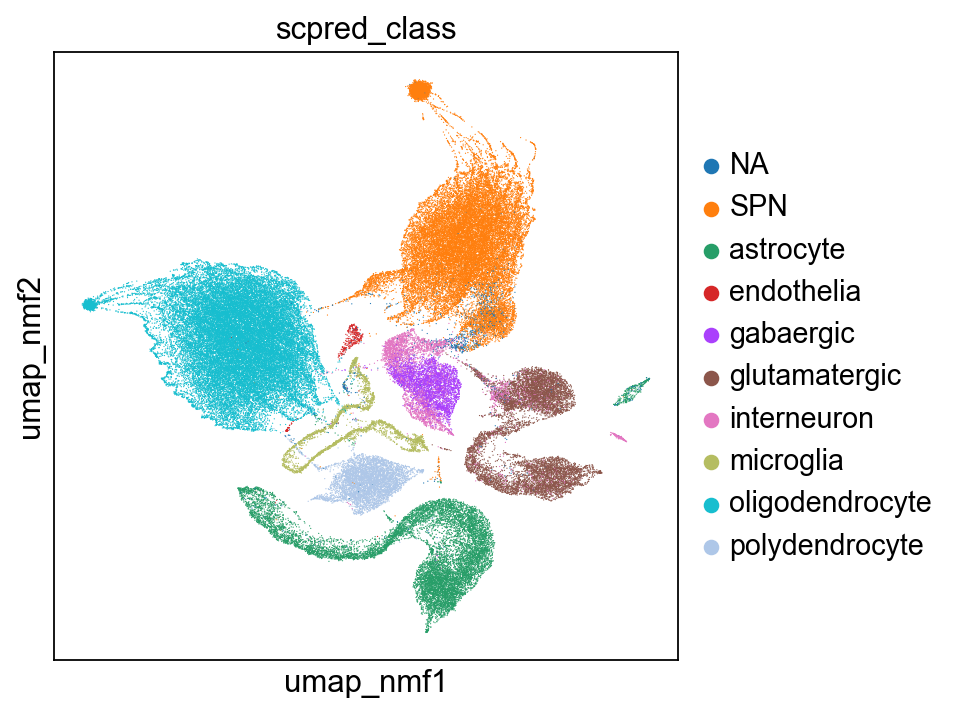

In [95]:
sc.pl.embedding(adata, basis='umap_nmf', color=['scpred_class'])

Definitely a bit wonky, but also definitely picking up on cell types.

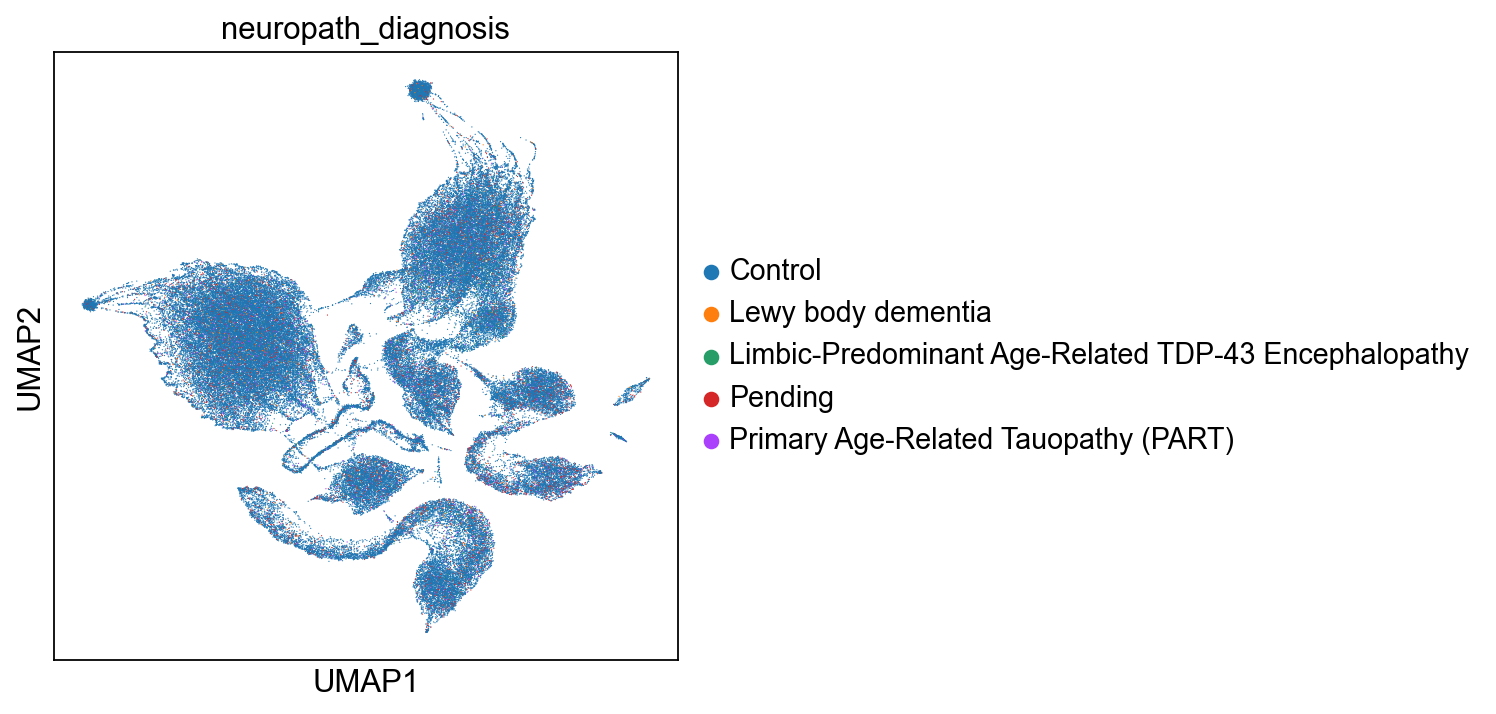

In [96]:
sc.pl.embedding(adata, basis='umap', color=['neuropath_diagnosis'])

## Project factors back to all genes

Now refit for all genes, not just the highly variable genes. In cNMF this involves solving an auxiliary linear regression problem.

## Results as a summary anndata

The results can be packaged up into an anndata object if desired, and perhaps saved that way as an h5ad file.

Here we omit the actual count matrix, since in theory it is too big to fit in memory.